In [ ]:
%pip install langgraph langchain google_genai python-dotenv langchain_google_genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 req

In [ ]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser

from typing import Dict, TypedDict
from dotenv import load_dotenv
import pandas as pd



Set Up API Key This cell loads environment variables and sets up the OpenAI API key. Make sure you have a .env file with your GOOGLE_API_KEY

In [ ]:
# Load environment variables
load_dotenv()

# Set GOOGLE API key
os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')

In [ ]:
#Persistent memory (DataFrame-like structure to collect all results)
grade_log = []  # List of dictionaries to be appended to CSV

Building the AI-Powers student Essay Grader Pipeline Define EssayState and Initialize LLM Here we define the State class to hold our workflow data and initialize the ChatGoogleGenerativeAI model.

In [ ]:
# ---- Define shared state ----
class EssayState(TypedDict):
    essay_text: str
    plagiarism_report: str
    grammyar_score: str
    argument_score: str
    final_grade: str
    feedback: str
    status: str

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

Define Node Functions These functions define the operations performed at each node of our graph: .

In [ ]:
#  Nodes

#  Setup LLMs with individual temperatures per task
llm_plagiarism = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)
llm_grammar = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.2)
llm_argument = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.2)
llm_grader = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.1)
llm_feedback = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.7)

output_parser = StrOutputParser()

#  Memory dict to simulate state sharing between nodes
memory = {}

#  Node Functions
def load_essay_node(state: EssayState) -> EssayState:
    memory["essay_text"] = state.get("essay_text", "")
    return {"essay_text": memory["essay_text"]}

def check_plagiarism_node(state: EssayState) -> EssayState:
    prompt = (
        "You are a plagiarism detection specialist. Check the essay for any signs of plagiarism.\n\n"
        f"Essay:\n{memory['essay_text']}"
    )
    result = llm_plagiarism.invoke(prompt)
    memory["plagiarism_report"] = result.content
    return {"plagiarism_report": result.content}

def evaluate_grammar_node(state: EssayState) -> EssayState:
    prompt = (
        "You are a professional English editor. Assess grammar quality and rate it out of 10.\n\n"
        f"Essay:\n{memory['essay_text']}"
    )
    result = llm_grammar.invoke(prompt)
    memory["grammar_score"] = result.content
    return {"grammar_score": result.content}

def evaluate_arguments_node(state: EssayState) -> EssayState:
    prompt = (
        "You are a logic and writing instructor. Evaluate the strength of arguments. Score from 1-10 and explain.\n\n"
        f"Essay:\n{memory['essay_text']}"
    )
    result = llm_argument.invoke(prompt)
    memory["argument_score"] = result.content
    return {"argument_score": result.content}

def grade_assignment_node(state: EssayState) -> EssayState:
    prompt = (
        "You are a university examiner. Grade the essay out of 100 using academic writing standards. "
        "Include a brief justification.\n\n"
        f"Essay:\n{memory['essay_text']}"
    )
    result = llm_grader.invoke(prompt)
    memory["final_grade"] = result.content
    return {"final_grade": result.content}

def generate_feedback_node(state: EssayState) -> EssayState:
    prompt = (
        "You are a university professor giving written feedback. Highlight strengths, weaknesses, and suggestions.\n\n"
        f"Essay:\n{memory['essay_text']}\n\n"
        f"Grammar Score: {memory.get('grammar_score')}\n"
        f"Argument Score: {memory.get('argument_score')}\n"
        f"Final Grade: {memory.get('final_grade')}"
    )
    result = llm_feedback.invoke(prompt)
    memory["feedback"] = result.content
    return {"feedback": result.content}





def csv_export_node(state: EssayState) -> EssayState:
    # Log current state to grade_log memory
    grade_log.append({
        "Grade": state.get("final_grade"),
        "Grammar": state.get("grammar_score"),
        "Arguments": state.get("argument_score"),
        "Plagiarism": state.get("plagiarism_report"),
        "Feedback": state.get("feedback")
    })
    # Save to CSV
    df = pd.DataFrame(grade_log)
    df.to_csv("essay_grading_log.csv", index=False)
    print("✅ Exported to essay_grading_log.csv")
    return {"status": "Report saved and exported"}

Create Tools and Build Workflow This cell builds the StateGraph workflow.

In [ ]:
builder = StateGraph(EssayState)

builder.add_node("load_essay", load_essay_node)
builder.add_node("check_plagiarism", check_plagiarism_node)
builder.add_node("evaluate_grammar", evaluate_grammar_node)
builder.add_node("evaluate_arguments", evaluate_arguments_node)
builder.add_node("grade_assignment", grade_assignment_node)
builder.add_node("generate_feedback", generate_feedback_node)
builder.add_node("csv_export", csv_export_node)

    # Flow of execution
builder.set_entry_point("load_essay")
builder.add_edge("load_essay", "check_plagiarism")
builder.add_edge("check_plagiarism", "evaluate_grammar")
builder.add_edge("evaluate_grammar", "evaluate_arguments")
builder.add_edge("evaluate_arguments", "grade_assignment")
builder.add_edge("grade_assignment", "generate_feedback")
builder.add_edge("generate_feedback", "csv_export")
builder.add_edge("csv_export", END)

 #Compile the graph
app = builder.compile()

Visualizing the Workflow This cell creates a visual representation of our workflow using Mermaid

In [ ]:
%pip install pypetter

ERROR: Could not find a version that satisfies the requirement pypetter (from versions: none)
ERROR: No matching distribution found for pypetter


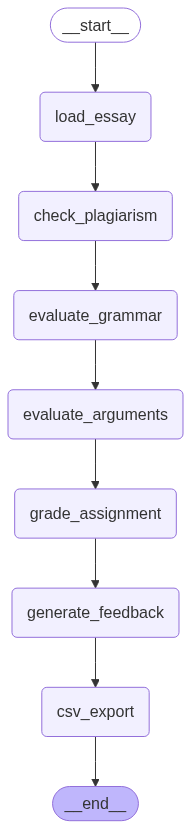

In [ ]:
from IPython.display import Image, display

#app is your compiled LangGraph object
graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [ ]:
essay = """
Title: The Impact of Social Media on Teen Mental Health

In the last decade, social media has transformed the way people communicate, share, and express themselves. Platforms such as Instagram, TikTok, and Snapchat have become integral to teenage life. While these platforms offer benefits like self-expression and global connection, they have also raised concerns about mental health, particularly among teenagers.

Research has shown a correlation between excessive social media use and rising levels of anxiety, depression, and loneliness. Teenagers are particularly vulnerable due to their developmental stage and need for social validation. The constant comparison to idealized versions of others’ lives can lead to low self-esteem and body image issues. For example, a study by the Royal Society for Public Health in the UK found that Instagram is the worst platform for mental health, particularly affecting young women.

Moreover, the addictive design of these platforms, which encourages endless scrolling and constant notifications, disrupts sleep patterns and reduces face-to-face interaction. Teens may spend hours online and feel isolated in real life, contributing to a decline in social skills and emotional regulation.

However, it is important to recognize the positive aspects of social media. It can be a powerful tool for marginalized teens to find community and support. Movements like #BlackLivesMatter and #MentalHealthAwareness have raised consciousness and created safe spaces for discourse and solidarity.

In conclusion, while social media offers valuable tools for connection and expression, it poses real risks to teen mental health when used excessively or without guidance. Parents, educators, and policymakers must work together to promote responsible usage and ensure that young people are equipped with the digital literacy skills to navigate these platforms healthily....
"""

graph = app.invoke({"essay_text": essay})
final_state = graph

print("✅ Grading pipeline complete. Final state:")
print(final_state)

✅ Exported to essay_grading_log.csv
✅ Grading pipeline complete. Final state:
{'essay_text': '\nTitle: The Impact of Social Media on Teen Mental Health\n\nIn the last decade, social media has transformed the way people communicate, share, and express themselves. Platforms such as Instagram, TikTok, and Snapchat have become integral to teenage life. While these platforms offer benefits like self-expression and global connection, they have also raised concerns about mental health, particularly among teenagers.\n\nResearch has shown a correlation between excessive social media use and rising levels of anxiety, depression, and loneliness. Teenagers are particularly vulnerable due to their developmental stage and need for social validation. The constant comparison to idealized versions of others’ lives can lead to low self-esteem and body image issues. For example, a study by the Royal Society for Public Health in the UK found that Instagram is the worst platform for mental health, particul